In [1]:
# Module 1: Import Libraries
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageChops
import zipfile
from google.colab import files

In [3]:
# Module 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Module 2: Set Dataset Paths
import os

# Set paths to dataset in Google Drive
image_dir = '/content/drive/MyDrive/datasets/montgomery_data/CXR_png'
left_mask_dir = '/content/drive/MyDrive/datasets/montgomery_data/ManualMask/leftMask'
right_mask_dir = '/content/drive/MyDrive/datasets/montgomery_data/ManualMask/rightMask'

In [5]:
# Module 3: Prepare Dataset
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image, ImageChops

class XRayDataset(Dataset):
    def __init__(self, image_dir, left_mask_dir, right_mask_dir, transform=None):
        self.image_dir = image_dir
        self.left_mask_dir = left_mask_dir
        self.right_mask_dir = right_mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        # Get the image filename
        img_filename = self.images[index]

        # Construct the full file paths for the image and corresponding masks
        img_path = os.path.join(self.image_dir, img_filename)
        left_mask_path = os.path.join(self.left_mask_dir, img_filename)  # No filename change
        right_mask_path = os.path.join(self.right_mask_dir, img_filename)  # No filename change

        # Load the image and masks
        image = Image.open(img_path).convert("RGB")
        left_mask = Image.open(left_mask_path).convert("L")
        right_mask = Image.open(right_mask_path).convert("L")

        # Combine the left and right masks by adding them
        combined_mask = ImageChops.add(left_mask, right_mask)

        # Apply transformations (if any)
        if self.transform:
            image = self.transform(image)
            combined_mask = self.transform(combined_mask)

        return image, combined_mask

# Define the transformations (resize to 256x256 and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create dataset and dataloader
train_dataset = XRayDataset(image_dir=image_dir, left_mask_dir=left_mask_dir, right_mask_dir=right_mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [6]:
# Module 4: U-Net Model Definition (Updated)
import torch.nn as nn # Import the necessary module
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(3, 64)
        self.encoder2 = self.conv_block(64, 128)
        self.encoder3 = self.conv_block(128, 256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        self.decoder3 = self.upconv_block(256, 128)
        self.decoder2 = self.upconv_block(128, 64)
        # Changed output size to 128x128
        self.decoder1 = nn.ConvTranspose2d(64, 1, kernel_size=4, stride=4)  # Upsampling to (128, 128)

    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),  # Upsampling
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.encoder1(x)  # (N, 64, 256, 256)
        x2 = self.pool(x1)  # (N, 64, 128, 128)
        x2 = self.encoder2(x2)  # (N, 128, 128, 128)
        x3 = self.pool(x2)  # (N, 128, 64, 64)
        x3 = self.encoder3(x3)  # (N, 256, 64, 64)

        x4 = self.decoder3(x3)  # (N, 128, 128, 128)
        x4 = x4 + x2  # Skip connection
        x5 = self.decoder2(x4)  # (N, 64, 256, 256)
        x6 = self.decoder1(x5)  # (N, 1, 128, 128)

        return x6

# Instantiate the model
model = UNet()

In [7]:
# Module 5: Loss Function and Optimizer
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam Optimizer

In [9]:
# Module 6: Training Loop (Resize Target Masks)
!pip install tqdm
from tqdm import tqdm # make sure to import tqdm

def train(model, loader, optimizer, criterion, epochs=5):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, masks in tqdm(loader):
            images = images
            # Ensure masks are float and have the same shape as outputs
            masks = masks.float()

            optimizer.zero_grad()
            outputs = model(images)
            # Check for shape mismatch and resize masks if necessary
            if outputs.shape != masks.shape:
                masks = F.interpolate(masks, size=outputs.shape[2:], mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(loader):.4f}")

# Reduce batch size to 8
train_dataset = XRayDataset(image_dir=image_dir, left_mask_dir=left_mask_dir, right_mask_dir=right_mask_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Train the model for 10 epochs
train(model, train_loader, optimizer, criterion, epochs=3)

100%|██████████| 18/18 [06:40<00:00, 22.28s/it]


Epoch [1/3], Loss: 0.2198


100%|██████████| 18/18 [06:45<00:00, 22.53s/it]


Epoch [2/3], Loss: 0.2088


100%|██████████| 18/18 [06:51<00:00, 22.84s/it]

Epoch [3/3], Loss: 0.1808


In [10]:
# Module 7: Save the Model
model_save_path = '/content/drive/MyDrive/unet_xray.pth'
torch.save(model.state_dict(), model_save_path)

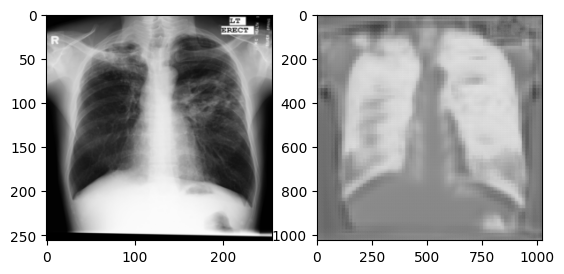

In [12]:
# Optional: Test the Model
import matplotlib.pyplot as plt

def visualize_prediction(model, loader):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(loader))
        images = images
        outputs = model(images)

        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(images[0].permute(1, 2, 0).cpu())  # Original Image
        ax[1].imshow(outputs[0].cpu().squeeze(), cmap='gray')  # Predicted Mask
        plt.show()

visualize_prediction(model, train_loader)